# P2 : Data wrangle OpenStreetMaps Data
## Data Wrangling with MongoDB

#### _HanByul Yang_

Map Area : part of Silicon Valley (including San José and Santa Clara), CA, United States 

https://www.openstreetmap.org/#map=13/37.3780/-121.9116
  * longitude -122.0554 ~ -121.8277
  * latitude 37.4588 ~ 37.2969

### 0. Preparing map files
#### 0-1. Creating map_sample.osm

Made an `.osm` file containing a sample part of the map region.
  * Used a given sample code in https://www.udacity.com/course/viewer#!/c-nd002/l-3168208620/m-3189488621
  * Executed `create_sample.py` for genereting `map_sample.osm` 

In [1]:
run create_sample.py

#### 0-2. Creating map.osm.json and Inserting into DB

Converted `map.osm` to `map.osm.json`
  * Used `data.py` modified version of Lesson_6 12-Preparing_for_Database
  * Referenced Lesson_4 02-Inserting_into_DB for inserting python dictionary to mongoDB
  * Auditing and cleaning addresses while parsing `map.osm` 

In [2]:
import data
map_data = data.process_map('map.osm', False)
data.insert_map_data(map_data)

### 1. Problem encountered in the Map

#### 1-1 Abbreviated street names
After downloading map file(`map.osm`), I audited it with `audit.py` from "Lesson 6, 11-Improving Street Names". I noticed some street names were abbreviated with several ways, such that "Bollinger Rd", "wilcox ave" or "Monroe St".

`audit.py` generated `audit.log` which has patterns of address with and `clean.log` which shows cleaned name.

In [3]:
run audit.py

E. Santa Clara St. -> E. Santa Clara Street
Bollinger Rd -> Bollinger Road
Homestead Rd -> Homestead Road
wilcox ave -> wilcox Avenue
E Santa Clara ave -> E Santa Clara Avenue
Zanker Rd., San Jose, CA -> Zanker Road., San Jose, CA
Monroe St -> Monroe Street
170 S Market St -> 170 S Market Street
Casa Verde St -> Casa Verde Street
South Bascom Ave -> South Bascom Avenue
Blake Ave -> Blake Avenue
Park Ave -> Park Avenue
Ann Arbor Ave -> Ann Arbor Avenue
The Alameda Ave -> The Alameda Avenue
E Santa Clara Ave -> E Santa Clara Avenue
Seaboard Ave -> Seaboard Avenue
Walsh Ave -> Walsh Avenue
N Blaney Ave -> N Blaney Avenue
Cabrillo Ave -> Cabrillo Avenue


#### 1-2 Inserting map data to DB
At first, I tried to insert map data (python dictionary format) from `map.osm.json` file. But JSON parser of python can't load large file.  
So I decided to use generated python dictionary that is returned function `process_map()`.

Here's code snippet for inserting map data to DB.
```python
def insert_map_data(data):
    from pymongo import MongoClient
    client = MongoClient("mongodb://localhost:27017")
    db = client.p2
    db.osm.insert(data)
```

#### 1-3 Slowness of parsing osm file
I used `xml.etree.ElementTree` package for paring osm file at first and it took quite a lot time.  
So I changed with `xml.etree.cElementTree` for parsing osm file. 

For example, running `audit.py` changes from 21.4s to 4.8s after changing parsing package.

### 2. Data Overview

This section contains basic statistics about the dataset and MongoDB queries used to gather them.

#### File sizes
`map.osm ........` 77.7 MB  
`map.osm.json ...` 86.1 MB

In [4]:
# Prepare DB
from pymongo import MongoClient
from pprint import pprint

client = MongoClient("mongodb://localhost:27017")
db = client.p2

##### Number of documents

In [5]:
print db.osm.find().count()

373812


##### Number of node

In [6]:
print db.osm.find({"type" : "node"}).count()

326104


##### Number of way

In [7]:
print db.osm.find({"type" : "way"}).count()

47299


##### Number of relation

In [8]:
print db.osm.find({"type" : "relation"}).count()

409


##### Number of unique users

In [9]:
print len(db.osm.distinct("created.user"))

730


##### Top 10 contributing user

In [10]:
query = [
    {"$group" : {"_id" : "$created.user", "count" : {"$sum":1}}},
    {"$sort" : {"count" : -1}},
    {"$limit" : 10}
]
result = list(db.osm.aggregate(query))
pprint(list(result))

[{u'_id': u'n76', u'count': 83868},
 {u'_id': u'mk408', u'count': 43265},
 {u'_id': u'Bike Mapper', u'count': 40394},
 {u'_id': u'matthieun', u'count': 27643},
 {u'_id': u'nmixter', u'count': 20997},
 {u'_id': u'KindredCoda', u'count': 12747},
 {u'_id': u'StellanL', u'count': 8302},
 {u'_id': u'woodpeck_fixbot', u'count': 7493},
 {u'_id': u'adbrown', u'count': 7172},
 {u'_id': u'oldtopos', u'count': 6847}]


##### Number of users appearing only once (having 1 post)

In [11]:
query = [
    {"$group" : {"_id" : "$created.user", "count" : {"$sum":1}}},
    {"$group":{"_id":"$count", "num_users":{"$sum":1}}},
    {"$sort":{"_id":1}}, 
    {"$limit":1}
]
result = list(db.osm.aggregate(query))
pprint(result)

[{u'_id': 1, u'num_users': 168}]


### 3. Additional Ideas

#### Contributor statistics  
The small number of users are contributed much of data but differences between top contributers are not big enough. There is an user ('woodpeck_fixbot') who seems to edit automatically. Here are some statistics.

In [12]:
query = [
    {"$group" : {"_id" : "$created.user", "count" : {"$sum":1}}},
    {"$sort" : {"count" : 1}},
]
user_cont_result = list(db.osm.aggregate(query))

query = [
    {"$group" : {"_id" : "$created.user", "count" : {"$sum":1}}},
    {"$sort" : {"count" : -1}},
    {"$limit" : 10},
    {"$group" : {"_id" : 0, "total" : {"$sum" : "$count"}}}
]

top10Docs = list(db.osm.aggregate(query))[0]['total']
totalDocs = db.osm.find().count()

topUserContribu = user_cont_result[-1]['count'] / float(totalDocs) * 100

one_pecent_docs = totalDocs * 0.01
user_1per = 0
doc_count = 0
for user_result in user_cont_result:
    if (doc_count > one_pecent_docs):
        break
    doc_count += user_result['count']
    user_1per += 1

print('Top user contribution ("{0}") - {1:.2f}%'.format(user_cont_result[-1]['_id'], topUserContribu))
print("Top 10 uesrs contributions    - {0:.2f}%".format((top10Docs / float(totalDocs) * 100)))
print('Combined number of users making up only 1% of posts - {0} (about {1:.0f}% of all users)'.format(user_1per, float(user_1per) / len(user_cont_result) * 100))

Top user contribution ("n76") - 22.44%
Top 10 uesrs contributions    - 69.21%
Combined number of users making up only 1% of posts - 518 (about 71% of all users)


#### Additional data exploration using MongoDB queries

##### Top 10 appearing amenities

In [13]:
query = [
    {"$match":{"amenity":{"$exists":1}}},
    {"$group":{"_id":"$amenity","count":{"$sum":1}}},
    {"$sort":{"count":-1}}, 
    {"$limit":10}
]
result = list(db.osm.aggregate(query))
pprint(result)

[{u'_id': u'parking', u'count': 769},
 {u'_id': u'restaurant', u'count': 458},
 {u'_id': u'school', u'count': 322},
 {u'_id': u'fire_hydrant', u'count': 247},
 {u'_id': u'place_of_worship', u'count': 184},
 {u'_id': u'fast_food', u'count': 175},
 {u'_id': u'bicycle_parking', u'count': 149},
 {u'_id': u'fuel', u'count': 113},
 {u'_id': u'cafe', u'count': 113},
 {u'_id': u'toilets', u'count': 86}]


##### Details about Top 1 amenity : parking
There are 17 free parking lot.

In [14]:
query = [
    {"$match":{"amenity":{"$exists":1}, "amenity":"parking"}},
    {"$group":{"_id":"$fee", "count":{"$sum":1}}},
    {"$sort":{"count":-1}},
    {"$limit":5}
]
result = list(db.osm.aggregate(query))
pprint(result)

[{u'_id': None, u'count': 745},
 {u'_id': u'no', u'count': 17},
 {u'_id': u'yes', u'count': 7}]


##### Details about Top 2 amenity : restaurant

In [15]:
query = [
    {"$match":{"amenity":{"$exists":1}, "amenity":"restaurant"}},
    {"$group":{"_id":"$cuisine", "count":{"$sum":1}}},
    {"$sort":{"count":-1}},
    {"$limit":10}
]
result = list(db.osm.aggregate(query))
pprint(result)

[{u'_id': None, u'count': 168},
 {u'_id': u'chinese', u'count': 38},
 {u'_id': u'indian', u'count': 29},
 {u'_id': u'mexican', u'count': 26},
 {u'_id': u'pizza', u'count': 23},
 {u'_id': u'american', u'count': 17},
 {u'_id': u'japanese', u'count': 17},
 {u'_id': u'thai', u'count': 15},
 {u'_id': u'italian', u'count': 13},
 {u'_id': u'sandwich', u'count': 12}]


#### Timestamp statistics
It is interested to me to find historical analysis of map data. I use for "R" and for analysis.  

In [16]:
query = [
    {"$project" : { "_id" : "$id",
                    "timestamp" : "$created.timestamp",
                    "year" : { "$year" : "$created.timestamp" },
                    "month" : { "$month" : "$created.timestamp" },
                    "dayOfWeek" : { "$dayOfWeek" : "$created.timestamp" },
                   }}
]
results = list(db.osm.aggregate(query))
%matplotlib inline
import rpy2
%load_ext rpy2.ipython
import pandas as pd
df = pd.DataFrame(results)
%R -i df

In [17]:
%%R
library(ggplot2)
library(scales)

In [18]:
%%R
summary(df$timestamp)

                 Min.               1st Qu.                Median 
"2007-03-08 02:02:45" "2011-01-03 15:43:58" "2013-05-11 19:33:44" 
                 Mean               3rd Qu.                  Max. 
"2012-08-15 15:51:56" "2014-03-01 03:25:05" "2015-04-13 08:08:55" 


Map data used this project were collected since March 2007.

##### Map data count by year

Yearly map data count chart shows two peaks. I guess first peak is related with growth of smartphone and second one was caused by the launch of pricing for google map in 2012. (reference : [wikipedia openstreetmap](http://en.wikipedia.org/wiki/OpenStreetMap#History) )

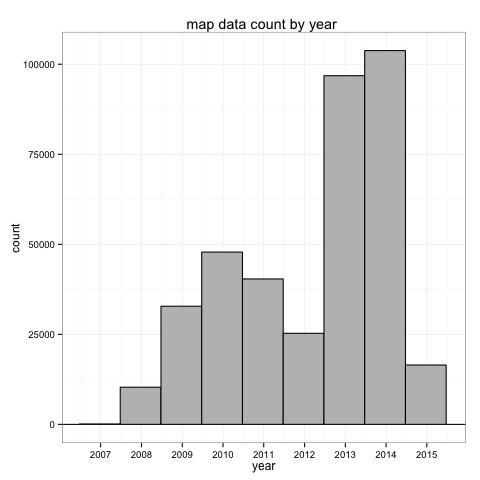

In [19]:
%%R
p <- ggplot(df, aes(timestamp, ..count..)) + 
    geom_histogram(colour = "black", fill = "gray", binwidth=365*24*60*60) +
    theme_bw() + xlab('year') + ggtitle('map data count by year ') +
    scale_x_datetime(breaks = date_breaks("12 months"),
                     labels = date_format("%Y"),
                     limits = c(as.POSIXct("2007-01-01"), 
                                as.POSIXct("2015-12-31")) )
p

##### Map data count by month
Note that histogram do not shows exact number of monthly created data. Its bin size is 30 days.

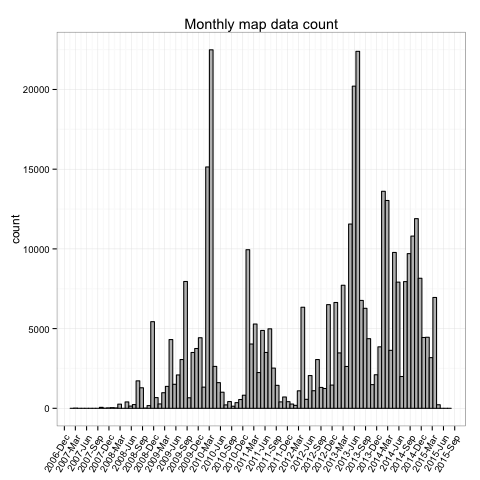

In [20]:
%%R
ggplot(df, aes(timestamp, ..count..)) + 
    geom_histogram(colour = "black", fill = "gray", binwidth=30*24*60*60) +
    theme_bw() + xlab(NULL) +
    scale_x_datetime(breaks = date_breaks("3 months"),
                     labels = date_format("%Y-%b"),
                     limits = c(as.POSIXct("2007-03-01"), 
                                as.POSIXct("2015-6-30")) ) +
    theme_bw() + xlab(NULL) + ggtitle('Monthly map data count') +
    theme(axis.text.x  = element_text(angle=60, hjust = 1, vjust = 1))

#### Conclusion
As the results, The top amenity of given map area is parking lot. But I couldn't analyze whether they are free or not because of missing tag value of 'fee'. I guess most of 'None' are require fee.  
Most popular cuisine is Chinese in given map area and No. 2 is indian. I think the results shows cultural diversity of silicon valley.

After this project of the map data, I realized that data for the area still have a room for improvements, although they have been well cleaned by many contributors for many years. Map also are changed over time. Recently personal devices such as smartphone have function that can trace of its location informations. I think using logs from personal devices can helps map data for correction latest informations and getting directions.